# Transit Agency Network generation

This notebook creates an abstraction of transit agency's network by generates an edge list (underlying network) using GTFS

You can also provide an edge list for reference if working off of an exisiting network

The underlying network is defined as follows; two census tracts are connected by an edge if they are 1. adjacent, 2. have a GTFS route that connects them

In [1]:
import gtfs_functions as gtfs
import geopandas as gpd
import pandas as pd

In [2]:
from gtfs_functions import Feed, map_gdf

## Import GTFS files

In [3]:
gtfs_path = 'gtfs.zip'

In [4]:
feed = Feed(gtfs_path,busiest_date=False)

In [5]:
trips=feed.trips

INFO:root:accessing trips
INFO:root:Reading "routes.txt".
INFO:root:Reading "trips.txt".
INFO:root:_trips is defined in stop_times
INFO:root:Reading "stops.txt".
INFO:root:Reading "stop_times.txt".
INFO:root:computing patterns


Drop duplicate shapes

In [6]:
shapes=trips.shape_id.drop_duplicates()

Each pattern is a different service

In [7]:
shapes=feed.shapes.merge(trips[['route_id','route_name','pattern','shape_id']].drop_duplicates(),on='shape_id')


INFO:root:Reading "shapes.txt".


In [8]:
type(shapes)

geopandas.geodataframe.GeoDataFrame

Show all routes

In [9]:
shapes

,shape_id,geometry,route_id,route_name,pattern
0,p_786568,"LINESTRING (-86.90276 35.90971, -86.90274 35.9...",13603,1 Red Route,957e2b3cbaf6286c46
1,p_786569,"LINESTRING (-86.87204 35.92212, -86.87222 35.9...",13604,2 Blue Route,0a236339d678664faf
2,p_786570,"LINESTRING (-86.82156 35.91611, -86.82157 35.9...",13604,2 Blue Route,a28d9088d7d684c066
3,p_786829,"LINESTRING (-86.88311 35.96411, -86.88274 35.9...",13603,1 Red Route,5ee00eff13b8510848
4,p_786863,"LINESTRING (-86.87204 35.92212, -86.87222 35.9...",13604,2 Blue Route,090941b51be63c73a3
5,p_786864,"LINESTRING (-86.81324 35.95615, -86.81335 35.9...",13604,2 Blue Route,bd845ba712e8b8f965


<AxesSubplot: >

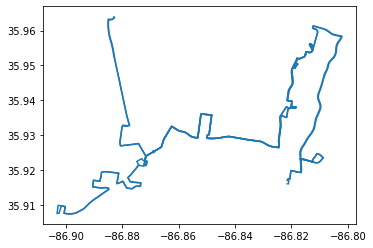

In [10]:
shapes.plot()

## Read in census tracts for city of interest

shapely file should be used

In [11]:
from shapely import wkt
census=pd.read_csv('frank_ct.csv')
census['geometry'] = census['geometry'].apply(wkt.loads)
census = gpd.GeoDataFrame(census, crs='epsg:4326')

Show census tracts

<AxesSubplot: >

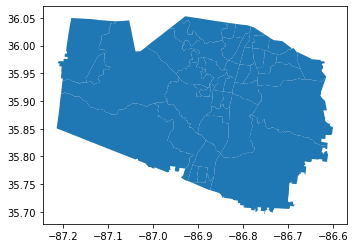

In [12]:
census.plot()

## Load underlying network

If using an underlying network to build off of 

In [13]:
network=pd.read_csv('./networks/edge_list.csv')

In [14]:
network

,Origin,Destination,cost_center,cost_OSM,INTPTLAT_left,INTPTLON_left,INTPTLAT_right,INTPTLON_right
0,509.07,509.05,2.998813,4.046428,35.902521,-86.836533,35.929133,-86.830736
1,509.07,509.06,2.366334,3.743814,35.902521,-86.836533,35.902921,-86.862741
2,509.07,510.02,7.242951,13.736089,35.902521,-86.836533,35.844580,-86.799592
3,509.07,509.08,2.996961,5.498478,35.902521,-86.836533,35.877714,-86.849665
4,501.03,501.05,7.870892,16.004152,35.881236,-86.684755,35.946817,-86.717995
...,...,...,...,...,...,...,...,...
215,508.02,509.04,2.441249,3.462610,35.919388,-86.869858,35.932603,-86.848231
216,508.02,506.01,4.263756,4.956158,35.919388,-86.869858,35.942712,-86.907407
217,508.02,506.04,6.359370,9.927847,35.919388,-86.869858,35.913071,-86.939886
218,508.02,509.06,1.936782,3.863607,35.919388,-86.869858,35.902921,-86.862741


Output routes

In [15]:
shapes

,shape_id,geometry,route_id,route_name,pattern
0,p_786568,"LINESTRING (-86.90276 35.90971, -86.90274 35.9...",13603,1 Red Route,957e2b3cbaf6286c46
1,p_786569,"LINESTRING (-86.87204 35.92212, -86.87222 35.9...",13604,2 Blue Route,0a236339d678664faf
2,p_786570,"LINESTRING (-86.82156 35.91611, -86.82157 35.9...",13604,2 Blue Route,a28d9088d7d684c066
3,p_786829,"LINESTRING (-86.88311 35.96411, -86.88274 35.9...",13603,1 Red Route,5ee00eff13b8510848
4,p_786863,"LINESTRING (-86.87204 35.92212, -86.87222 35.9...",13604,2 Blue Route,090941b51be63c73a3
5,p_786864,"LINESTRING (-86.81324 35.95615, -86.81335 35.9...",13604,2 Blue Route,bd845ba712e8b8f965


In [ ]:
census

## Join census tracts and routes into one dataframe

In [16]:
census_routes=gpd.sjoin(census,shapes)

Get intersection of both census networks for census routes

In [17]:
intersection_census_routes=census_routes[['NAME','route_id','pattern']]
intersection_census_routes['route']=intersection_census_routes.apply(lambda x: f'{x.route_id}_{x.pattern}',axis=1)
intersection_census_routes=intersection_census_routes.drop(['route_id','pattern'],axis=1)
intersection_census_origin=intersection_census_routes.rename(columns={"NAME": "Origin","route":"Route_Origin"})
intersection_census_destination=intersection_census_routes.rename(columns={"NAME": "Destination","route":"Route_Destination"})

In [18]:
intersection_census_destination


,Destination,Route_Destination
2,503.07,13604_a28d9088d7d684c066
4,507.02,13604_a28d9088d7d684c066
6,509.04,13604_a28d9088d7d684c066
26,502.11,13604_a28d9088d7d684c066
31,509.05,13604_a28d9088d7d684c066
38,510.01,13604_a28d9088d7d684c066
44,508.01,13604_a28d9088d7d684c066
45,508.02,13604_a28d9088d7d684c066
2,503.07,13604_090941b51be63c73a3
4,507.02,13604_090941b51be63c73a3


## Merge route origin and route destinations with underlying network

In [19]:
network_merge=network.merge(intersection_census_origin).merge(intersection_census_destination)


drop when Route_origin not equal to Route_Destination

In [20]:
network_merge_selected=network_merge.query('Route_Origin==Route_Destination')

In [21]:
network_unique=network_merge_selected[network.columns].drop_duplicates()


In [22]:
network_unique


,Origin,Destination,cost_center,cost_OSM,INTPTLAT_left,INTPTLON_left,INTPTLAT_right,INTPTLON_right
0,503.07,507.02,3.879585,5.678890,35.957686,-86.822415,35.954426,-86.865233
24,509.04,507.02,2.866389,5.276947,35.932603,-86.848231,35.954426,-86.865233
52,506.01,507.02,4.020924,4.542918,35.942712,-86.907407,35.954426,-86.865233
64,507.01,507.02,2.538726,4.223800,35.962192,-86.891704,35.954426,-86.865233
72,508.02,507.02,3.910094,5.222168,35.919388,-86.869858,35.954426,-86.865233
108,503.07,509.04,3.629183,6.151598,35.957686,-86.822415,35.932603,-86.848231
124,507.02,509.04,2.866389,5.272173,35.954426,-86.865233,35.932603,-86.848231
148,509.05,509.04,1.625079,2.265307,35.929133,-86.830736,35.932603,-86.848231
164,508.02,509.04,2.441249,3.462610,35.919388,-86.869858,35.932603,-86.848231
188,503.07,502.11,2.142457,3.802722,35.957686,-86.822415,35.949708,-86.800789


## Save new transit agency network to csv

In [24]:
network_unique.to_csv("./ta_edge_list.csv", index=False)